# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import json
import requests
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Reshape, Flatten, Activation
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [41]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
# hist = pd.DataFrame(json.loads(res.content.decode('utf-8'))['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# hist.head()

hist = pd.read_csv('Datasets/gemini_BTCUSD_1hr_mod.csv')
hist.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1559433600000,2019-06-02 00:00:00,BTCUSD,8566.10,8567.20,8546.38,8567.20,0.899330
1,1559430000000,2019-06-01 23:00:00,BTCUSD,8587.25,8598.10,8527.58,8566.10,156.493022
2,1559426400000,2019-06-01 22:00:00,BTCUSD,8598.89,8604.16,8542.44,8587.25,11.841891
3,1559422800000,2019-06-01 21:00:00,BTCUSD,8543.90,8609.96,8541.67,8598.89,18.957024
4,1559419200000,2019-06-01 20:00:00,BTCUSD,8538.75,8569.69,8532.23,8543.90,18.051794


In [42]:
#hist = hist.drop(['high','low','open','volumefrom','volumeto'], axis=1)
hist = hist.drop(['Unix Timestamp','Date','Symbol','Open','High','Low','Volume'], axis=1)
hist.head()

,Close
0,8567.20
1,8566.10
2,8587.25
3,8598.89
4,8543.90


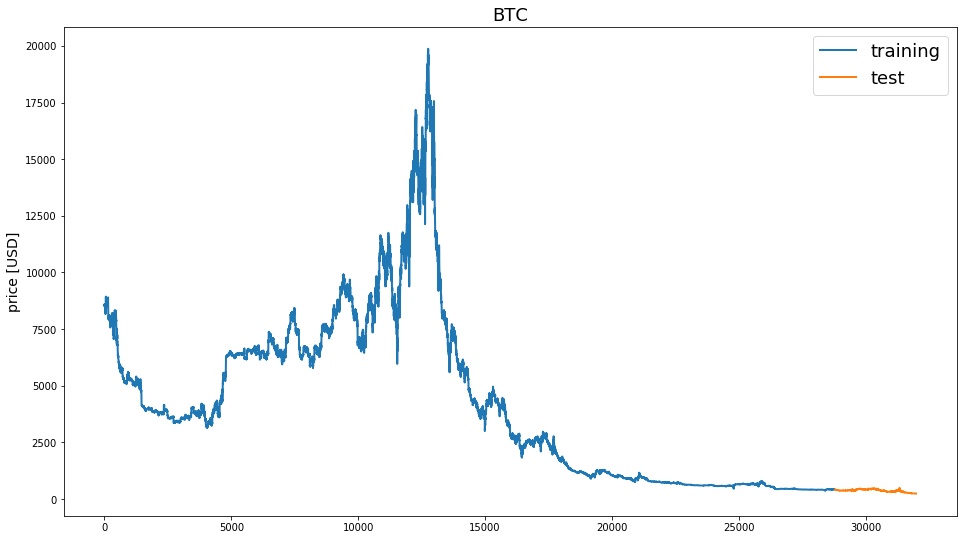

In [43]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
    
train, test = train_test_split(hist, test_size=0.1)
line_plot(train.Close, test.Close, 'training', 'test', 'BTC')

In [44]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, window=7, zero_base=True, test_size=0.1):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.Close[window:].values
    y_test = test_data.Close[window:].values
    if zero_base:
        y_train = y_train / train_data.Close[:-window].values - 1
        y_test = y_test / test_data.Close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [45]:
print(X_train.shape)
print(X_train.shape)
print(y_test.shape)
print(y_test.shape)

(28775, 7, 1)
(28775, 7, 1)
(3191,)
(3191,)


In [46]:
TIME_STEPS = 7
BATCH_SIZE_OUT = 4 # 16 was better
LR = 0.005
# epochs = 150
EPOCHS = 50

In [47]:
def create_generator():
#     generator=Sequential()
#     generator.add(Dense(units=128,input_dim=8))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=256))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=512))
#     generator.add(LeakyReLU(0.2))
    
#     generator.add(Dense(units=8, activation='tanh'))
    
#     #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
#     generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 6 below = x_t.shape[2]
#     generator = Sequential()
#     #generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform', return_sequences=False)) 
#     # stateful = true breaks the model (https://github.com/keras-team/keras/issues/9385)
#     generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=True)) 
#     generator.add(Dense(8,activation='relu'))
#     generator.add(Dropout(0.7))
#     generator.add(LSTM(8, return_sequences=False))
#     generator.add(Dense(1,activation='sigmoid'))
#     #generator.add(Reshape((TIME_STEPS, 1)))
#     optimizer = RMSprop(lr=LR, decay=3e-8)
#     #generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#     generator.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1), return_sequences=False))
    generator.add(LeakyReLU(0.5))
    generator.add(Dropout(0.5))
    generator.add(Dense(1))
    generator.add(Activation('tanh'))
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    generator.compile(loss='mean_squared_error', optimizer=optimizer)

    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (4, 16)                   1152      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (4, 16)                   0         
_________________________________________________________________
dropout_13 (Dropout)         (4, 16)                   0         
_________________________________________________________________
dense_17 (Dense)             (4, 1)                    17        
_________________________________________________________________
activation_5 (Activation)    (4, 1)                    0         
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [48]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    #discriminator.add(Dense(units=512, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 1)))
    discriminator.add(Dense(units=16, batch_input_shape=(8, TIME_STEPS, 1)))
    
    #discriminator.add(Dense(units=512,input_dim=6))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
       
    
#     discriminator.add(Dense(units=256))
#     discriminator.add(LeakyReLU(0.2))
#     discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=8))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    
    #discriminator.add(Reshape((5, 1)))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

#     discriminator = Sequential()
#     discriminator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_OUT, TIME_STEPS, 6), dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform', return_sequences=False)) 
#     discriminator.add(Dense(8,activation='relu'))
#     discriminator.add(Dropout(0.7))
#     discriminator.add(Dense(1,activation='sigmoid'))

#     discriminator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (8, 7, 16)                32        
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (8, 7, 16)                0         
_________________________________________________________________
dropout_14 (Dropout)         (8, 7, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (8, 7, 8)                 136       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (8, 7, 8)                 0         
_________________________________________________________________
dropout_15 (Dropout)         (8, 7, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (8, 7, 1)                 9         
Total para

In [49]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(TIME_STEPS, 1)) # x_t.shape[2] = 6
    #Input(shape=(None, latent_dim))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='mean_squared_error', optimizer=optimizer)
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 7, 1)              0         
_________________________________________________________________
sequential_9 (Sequential)    multiple                  1169      
_________________________________________________________________
sequential_10 (Sequential)   multiple                  177       
Total params: 1,346
Trainable params: 1,169
Non-trainable params: 177
_________________________________________________________________


In [50]:
import keras.backend as K

adversarial_loss = []
discrimator_loss = []
gen_samples = []

#K.clear_session()
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
#(X_train, y_train, X_val, X_test, y_val, y_test) = load_data(x_train_out, x_test_out, BATCH_SIZE_OUT)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            #noise = np.random.normal(0,1, [BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]])
            #print(X_train.shape)
            
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=BATCH_SIZE_OUT)]
            
            
            dim_0 = generated_prices.shape[0] - TIME_STEPS
            dim_0 = generated_prices.shape[0]
            gen_prices = np.zeros((dim_0, TIME_STEPS, 1))
            
            for j in range(dim_0):
                gen_prices[j] = generated_prices[j]

#             print('Shapes 1')
#             print(noise.shape)
#             print(prices_batch.shape)
#             print(generated_prices.shape)     
#             print(gen_prices.shape)
#             print('>>>>>>>>>>>gen_prices>>>>>>>')            
#             print(gen_prices)
#             #print(prices_batch)
#             #print(generated_prices)
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, gen_prices])
            
            # Labels for generated and real data
            #y_dis = np.zeros(2*batch_size)
            #y_dis = np.zeros(shape=(2*BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]))
            y_dis = np.zeros(shape=(X.shape[0], TIME_STEPS, X_train.shape[2]))
            #y_dis[:batch_size]=0.9
            y_dis[:int((X.shape[0]/2))]=0.9
            #y_dis[0,:,batch_size]=0.9
            
#             print('Shapes 2')
#             print(X.shape)
#             print(y_dis.shape)
#             print('>>>>>>>>>>>x>>>>>>>')
#             print(X)
#             print('>>>>>>>>>>>y_dis>>>>>>>')            
#             print(y_dis)
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise = np.random.normal(0,1, [batch_size, 8])
            #y_gen = np.ones(batch_size)
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
            #y_gen = np.ones(shape=(noise.shape[0], TIME_STEPS, X_train.shape[2]))
            y_gen = np.ones(BATCH_SIZE_OUT)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
#             print('Shapes 3')
#             print(noise.shape)
#             print(y_gen.shape)
            
            #training the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                #log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                #log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                log_mesg = "%d: [D loss: %f]" % (e, d_loss)
                log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
#         if e == 1 or e % 5 == 0:
#             # generate synthetic dataset
#             gen_samples_set = []
#             for batch_idx in range(int(len(X_train) / batch_size)):
#             # for batch_idx in range(int(len(X_train) / 100)):
#                 # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
#                 #noise= np.random.normal(0,1, [batch_size, 8])
#                 noise = np.float32(np.random.normal(size=[BATCH_SIZE_OUT, TIME_STEPS, X_train.shape[2]]))
#                 generated_data = generator.predict(noise)
#                 gen_samples_set.append(generated_data)

#             gen_samples = np.vstack(gen_samples_set)

In [51]:
#training(400,128)
training(50,12)

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12 [00:00<?, ?it/s]

1: [D loss: 0.692912]  [A loss: 0.256001]
Epoch 2
2: [D loss: 0.693100]  [A loss: 0.259571]
Epoch 3


  0%|          | 0/12 [00:00<?, ?it/s]

3: [D loss: 0.696406]  [A loss: 0.262036]
Epoch 4
4: [D loss: 0.690777]  [A loss: 0.260528]
Epoch 5


  0%|          | 0/12 [00:00<?, ?it/s]

5: [D loss: 0.692075]  [A loss: 0.255652]
Epoch 6
6: [D loss: 0.691251]  [A loss: 0.261439]
Epoch 7


  0%|          | 0/12 [00:00<?, ?it/s]

7: [D loss: 0.691666]  [A loss: 0.264631]
Epoch 8
8: [D loss: 0.691965]  [A loss: 0.266688]
Epoch 9


  0%|          | 0/12 [00:00<?, ?it/s]

9: [D loss: 0.689354]  [A loss: 0.257326]
Epoch 10
10: [D loss: 0.685461]  [A loss: 0.262140]
Epoch 11


  0%|          | 0/12 [00:00<?, ?it/s]

11: [D loss: 0.689457]  [A loss: 0.285648]
Epoch 12
12: [D loss: 0.689263]  [A loss: 0.269358]
Epoch 13


  0%|          | 0/12 [00:00<?, ?it/s]

13: [D loss: 0.691952]  [A loss: 0.273159]
Epoch 14
14: [D loss: 0.687385]  [A loss: 0.296522]
Epoch 15


  0%|          | 0/12 [00:00<?, ?it/s]

15: [D loss: 0.690032]  [A loss: 0.268586]
Epoch 16
16: [D loss: 0.683634]  [A loss: 0.278963]
Epoch 17


  0%|          | 0/12 [00:00<?, ?it/s]

17: [D loss: 0.683025]  [A loss: 0.292110]
Epoch 18
18: [D loss: 0.683986]  [A loss: 0.281468]
Epoch 19


  0%|          | 0/12 [00:00<?, ?it/s]

19: [D loss: 0.691469]  [A loss: 0.281585]
Epoch 20
20: [D loss: 0.685820]  [A loss: 0.287005]
Epoch 21


  0%|          | 0/12 [00:00<?, ?it/s]

21: [D loss: 0.684015]  [A loss: 0.290397]
Epoch 22
22: [D loss: 0.680157]  [A loss: 0.300611]
Epoch 23


 50%|█████     | 6/12 [00:00<00:00, 51.45it/s]

23: [D loss: 0.694325]  [A loss: 0.279956]
Epoch 24


 50%|█████     | 6/12 [00:00<00:00, 52.68it/s]

24: [D loss: 0.687863]  [A loss: 0.279745]
Epoch 25


  0%|          | 0/12 [00:00<?, ?it/s]

25: [D loss: 0.689357]  [A loss: 0.284919]
Epoch 26
26: [D loss: 0.691153]  [A loss: 0.285271]
Epoch 27


 33%|███▎      | 4/12 [00:00<00:00, 38.62it/s]

27: [D loss: 0.682221]  [A loss: 0.283502]
Epoch 28


100%|██████████| 12/12 [00:00<00:00, 67.20it/s]

28: [D loss: 0.681305]  [A loss: 0.298116]
Epoch 29
29: [D loss: 0.687517]  [A loss: 0.288581]
Epoch 30



 50%|█████     | 6/12 [00:00<00:00, 54.24it/s]

30: [D loss: 0.690473]  [A loss: 0.314087]
Epoch 31


 42%|████▏     | 5/12 [00:00<00:00, 46.91it/s]

31: [D loss: 0.685873]  [A loss: 0.292891]
Epoch 32


 50%|█████     | 6/12 [00:00<00:00, 57.69it/s]

32: [D loss: 0.688865]  [A loss: 0.292190]
Epoch 33


 50%|█████     | 6/12 [00:00<00:00, 57.94it/s]

33: [D loss: 0.686426]  [A loss: 0.295174]
Epoch 34


 33%|███▎      | 4/12 [00:00<00:00, 38.59it/s]

34: [D loss: 0.684927]  [A loss: 0.297818]
Epoch 35


 58%|█████▊    | 7/12 [00:00<00:00, 61.22it/s]

35: [D loss: 0.688081]  [A loss: 0.293927]
Epoch 36


 42%|████▏     | 5/12 [00:00<00:00, 49.52it/s]

36: [D loss: 0.693224]  [A loss: 0.296412]
Epoch 37


  0%|          | 0/12 [00:00<?, ?it/s]

37: [D loss: 0.690738]  [A loss: 0.293844]
Epoch 38
38: [D loss: 0.683746]  [A loss: 0.331678]
Epoch 39


 50%|█████     | 6/12 [00:00<00:00, 52.73it/s]

39: [D loss: 0.681896]  [A loss: 0.300596]
Epoch 40


 58%|█████▊    | 7/12 [00:00<00:00, 63.27it/s]

40: [D loss: 0.689559]  [A loss: 0.301463]
Epoch 41


 50%|█████     | 6/12 [00:00<00:00, 58.05it/s]

41: [D loss: 0.686156]  [A loss: 0.320572]
Epoch 42


 50%|█████     | 6/12 [00:00<00:00, 58.07it/s]

42: [D loss: 0.690993]  [A loss: 0.300308]
Epoch 43


  0%|          | 0/12 [00:00<?, ?it/s]

43: [D loss: 0.683057]  [A loss: 0.307340]
Epoch 44
44: [D loss: 0.685678]  [A loss: 0.308219]
Epoch 45


 42%|████▏     | 5/12 [00:00<00:00, 41.26it/s]

45: [D loss: 0.688346]  [A loss: 0.306005]
Epoch 46


  0%|          | 0/12 [00:00<?, ?it/s]

46: [D loss: 0.687735]  [A loss: 0.305783]
Epoch 47
47: [D loss: 0.686875]  [A loss: 0.306035]
Epoch 48


  0%|          | 0/12 [00:00<?, ?it/s]

48: [D loss: 0.684786]  [A loss: 0.303953]
Epoch 49
49: [D loss: 0.686438]  [A loss: 0.313107]
Epoch 50


100%|██████████| 12/12 [00:00<00:00, 77.91it/s]

50: [D loss: 0.688324]  [A loss: 0.316632]


Text(0,0.5,'Loss')

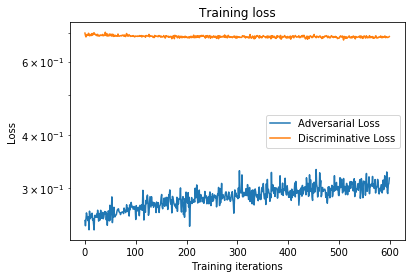

In [52]:
# adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
# discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [58]:
targets = test.Close[7:]
preds = gan.predict(X_test).squeeze()

In [59]:
metrics.mean_absolute_error(preds, y_test)

0.45185275387017115

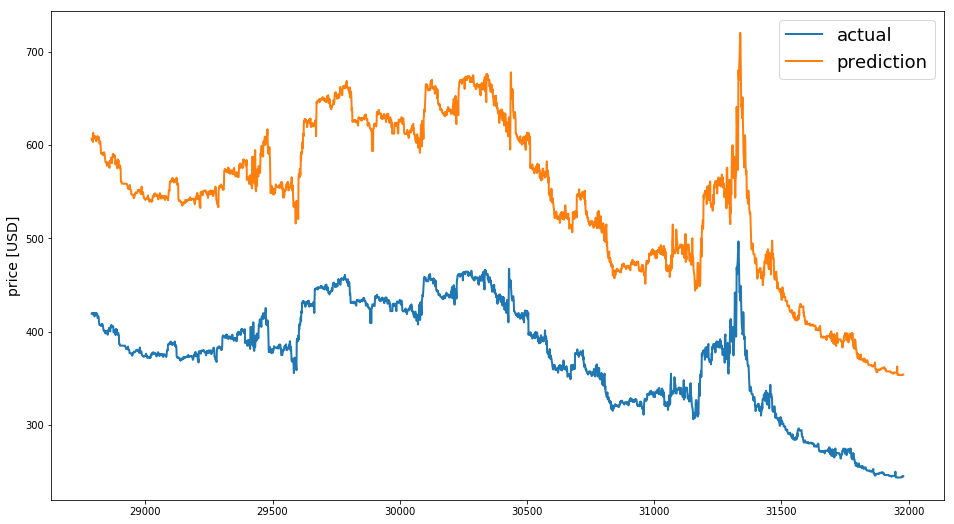

In [60]:
preds = test.Close.values[:-7] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction')

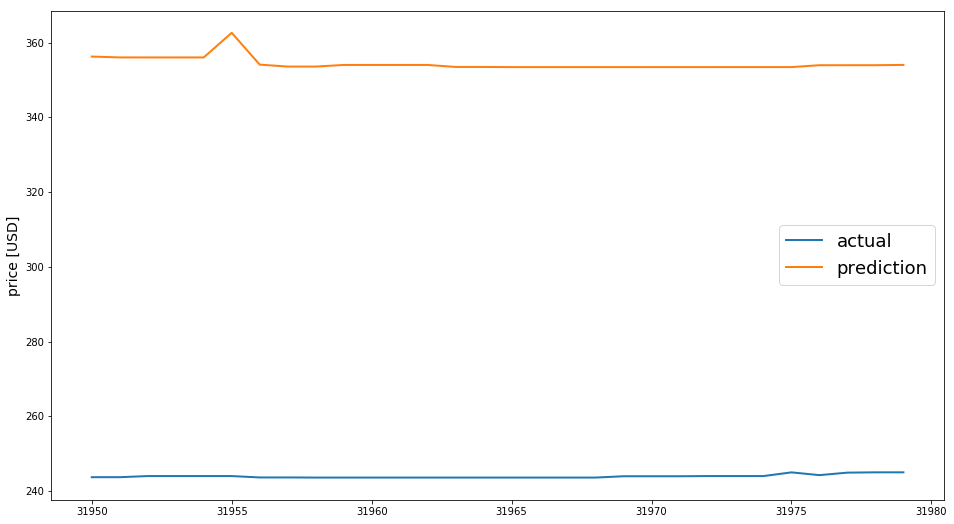

In [65]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction')